In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

In [2]:
from src.constants import vocab
from src.dataset import LipDataset, collate_fn
from src.utils import char_to_num, num_to_char, get_word2idx_idx2word

In [3]:
# from src import download_data

# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# download_data.download_data(url)

In [43]:
word2idx, idx2word = get_word2idx_idx2word(vocab)

data_transform = transforms.Compose(
    [
        transforms.ToPILImage(),                      # Convert the OpenCV image (NumPy array) to a PIL image
        # transforms.Grayscale(num_output_channels=3),  # Convert to grayscale
        transforms.ToTensor(),                        # Convert the PIL image to a PyTorch tensor (values between 0 and 1)
        # transforms.Normalize(mean=[0.5], std=[0.5])
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

data_dir = "data/s1"
label_dir = "data/alignments/s1"

dataset = LipDataset(data_dir, label_dir, transform=data_transform, vocab=vocab, word2idx=word2idx, idx2word=idx2word)

In [44]:
frames, label = dataset[0]
print(frames.shape, label.shape)

torch.Size([75, 3, 46, 140]) torch.Size([21])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6113086..2.0715413].


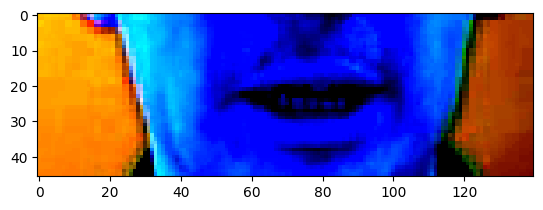

In [45]:
plt.imshow(frames[50].permute(1, 2, 0), cmap='gray')

In [46]:
print(''.join(num_to_char(label.tolist(), idx2word)))

bin blue at f two now


In [47]:
# def collate_fn(batch):
#     frames, labels = zip(*batch)

#     # Pad the frames to the same length
#     max_len = max([f.shape[0] for f in frames])
#     frames = [torch.nn.functional.pad(input=f, pad=(0, 0, 0, 0, 0, 0, 0, max_len - f.shape[0]), mode='constant', value=0) for f in frames] 
    
#     # Pad the labels to the same length
#     max_len = max([l.shape[0] for l in labels])  # noqa: E741
#     labels = [torch.nn.functional.pad(input=l, pad=(0, max_len - l.shape[0]), mode='constant', value=word2idx['<PAD>']) for l in labels]  # noqa: E741
    
#     return torch.stack(frames), torch.stack(labels)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=lambda x: collate_fn(x, word2idx['<PAD>']), pin_memory=True)

In [48]:
frames, labels = next(iter(dataloader))
print(frames.shape, labels.shape)

torch.Size([32, 75, 3, 46, 140]) torch.Size([32, 28])


In [49]:
video = frames[0].permute(0, 2, 3, 1)  # Resulting shape: [75, 46, 140, 3]

# Step 2: Clip values to [0, 1] and scale to [0, 255] for visualization
video = torch.clamp(video, 0, 1) * 255
video = video.type(torch.uint8)  # Convert to uint8 for image saving

# Convert to numpy for imageio
video_np = video.numpy()

# Step 3: Save as GIF
imageio.mimsave('test.gif', video_np, duration=0.1)